In [1]:
import warnings
warnings.filterwarnings('ignore')

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import random
import keras
import os, glob
import librosa, librosa.display

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix

from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential, model_from_json
from keras import backend as K

from imblearn.over_sampling import RandomOverSampler

%load_ext autoreload
%autoreload 2


2023-05-11 12:48:58.817680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 12:48:58.942292: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-11 12:48:59.674067: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2023-05-11 12:48:59.674156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64]

ModuleNotFoundError: No module named 'imblearn'

In [3]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [2]:
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from settings import *

In [7]:
len(glob.glob(DATA_DIR_PIANO + "**/*.wav"))

100

### Generate Metadata

In [4]:
def df_info(f):
    def inner(df, *args, **kwargs):
        result = f(df, *args, **kwargs)
        print(f"After applying {f.__name__}, shape of df = {result.shape }")
        print(f"Columns of df are {df.columns}\n")
        return result
    return inner

# Construct Dataframe with all required values
@df_info
def construct_dataframe(df, instrument='Guitar'):
    """
    Construct Dataframe with all required values
    """
    if instrument=='Guitar':
        file_path = glob.glob(DATA_DIR_GUITAR + "**/*.wav")
        df['file_path'] = file_path
        df['file_path'] = df['file_path'].map(lambda x: x[x.rindex('Only/')+len('Only/'):])
        df['file_name'] = df['file_path'].map(lambda x: x[x.rindex('/')+1:])
        df['class_name'] = df['file_path'].map(lambda x: x[:x.index('/')])
        df['class_ID'] = df['class_name'].map(lambda x: CLASSES_MAP[x])
    elif instrument=='Piano':
        file_path = glob.glob(DATA_DIR_PIANO + "**/*.wav")
        df['file_path'] = file_path
        df['file_path'] = df['file_path'].map(lambda x: x[x.rindex('Piano/')+len('Piano/'):])
        df['file_name'] = df['file_path'].map(lambda x: x[x.rindex('/')+1:])
        df['class_name'] = df['file_path'].map(lambda x: x[:x.index('/')])
        df['class_ID'] = df['class_name'].map(lambda x: CLASSES_MAP[x])
    return df.copy()

# Extract spectrogram from audio
@df_info
def get_spectrogram(df):
    df['audio_series'] = df['file_path'].map(lambda x: librosa.load(DATA_DIR_GUITAR + x, duration=2))
    df['y'] = df['audio_series'].map(lambda x: x[0])
    df['sr'] = df['audio_series'].map(lambda x: x[1])
    df['spectrogram'] = df.apply(lambda row: librosa.feature.melspectrogram(y=row['y'], sr=row['sr']), axis=1)
    df.drop(columns='audio_series', inplace=True)
    return df

@df_info
def get_count(df):
    return df['class_name'].value_counts()

@df_info
def add_shape(df):
    df['shape'] = df['spectrogram'].map(lambda x: x.shape)
    return df

### Generate raw data

In [5]:
file_path = glob.glob(DATA_DIR_GUITAR + "**/*.wav")
data_df_raw = construct_dataframe(pd.DataFrame(), instrument='Piano')\
                            .pipe(get_spectrogram)\
                            .pipe(add_shape)
            


After applying construct_dataframe, shape of df = (100, 4)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID'], dtype='object')



KeyboardInterrupt: 

In [11]:
get_count(data_df_raw)

After applying get_count, shape of df = (10,)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape'],
      dtype='object')



g     10
bm    10
d     10
am    10
a     10
e     10
c     10
f     10
em    10
dm    10
Name: class_name, dtype: int64

### Save raw data


- csv just for human readable format
- pkl is actually used since it can store numpy arrays

In [12]:
data_df_raw.to_csv(os.path.join(METADATA_DIR_RAW, 'data_piano.csv'), index=False)
data_df_raw.to_pickle(os.path.join(METADATA_DIR_RAW, 'data_piano.pkl'))

In [9]:
data_df_raw = pd.read_pickle(os.path.join(METADATA_DIR_RAW, 'data_piano.pkl'))

In [9]:
data_df_raw.head()

,file_path,file_name,class_name,class_ID,y,sr,spectrogram,shape
0,em/em8.wav,em8.wav,em,7,"[-0.00038043846, -0.0006151192, -0.00049563346...",22050,"[[0.00012578518248171133, 0.000171102419808094...","(128, 87)"
1,em/em6.wav,em6.wav,em,7,"[0.00013434298, 0.00014084009, 0.00013988353, ...",22050,"[[0.00012171085505027163, 0.000294527881420276...","(128, 72)"
2,em/em7.wav,em7.wav,em,7,"[0.00017490347, 0.00021111853, 0.00017389591, ...",22050,"[[0.00031737319756304863, 0.000196246765195240...","(128, 80)"
3,em/em3.wav,em3.wav,em,7,"[-0.00078138773, -0.00071918656, -0.0003369788...",22050,"[[0.00032534225279899745, 0.000222313769747151...","(128, 79)"
4,em/em5.wav,em5.wav,em,7,"[0.00057056657, 0.0005140589, -0.0009413323, -...",22050,"[[0.006174738186107656, 0.0032572471898456396,...","(128, 70)"


### Process and save processed data

- csv just for human readable format
- pkl is actually used since it can store numpy arrays

In [10]:
# Maintain same shape
@df_info
def clean_shape(df):
    max_shape = df['spectrogram'].map(lambda x: x.shape).value_counts().index[0]
    print(f"The most frequent shape is {max_shape}")
    df['shape'] = df['spectrogram'].map(lambda x: x.shape)
    df = df[df['shape']==max_shape]
    df.drop(columns='shape', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

@df_info
def process(df):
    df = (df.pipe(clean_shape)
                .pipe(over_sample)
    )
    df = df[['spectrogram','class_ID', 'class_name']]
    return df

#Over sampling data
@df_info
def over_sample(df):
    oversample = RandomOverSampler(sampling_strategy='auto')
    X, y = df['spectrogram'].values, df['class_ID'].values
    X = X.reshape(-1, 1)
    X, y = oversample.fit_resample(X, y)
    df = pd.DataFrame()
    df['spectrogram'] = pd.Series([np.array(x[0]) for x in X])
    df['class_ID'] = pd.Series(y)
    df['class_name'] = df['class_ID'].map(lambda x: get_class(x))
    return df

def get_class(class_ID):
    return list(CLASSES_MAP.keys())[list(CLASSES_MAP.values()).index(class_ID)]

In [11]:
data_df_processed = process(data_df_raw)

The most frequent shape is (128, 87)
After applying clean_shape, shape of df = (13, 7)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape'],
      dtype='object')

After applying over_sample, shape of df = (28, 3)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram'],
      dtype='object')

After applying process, shape of df = (28, 3)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape'],
      dtype='object')



In [17]:
get_count(data_df_processed)

After applying get_count, shape of df = (7,)
Columns of df are Index(['spectrogram', 'class_ID', 'class_name'], dtype='object')



am    4
d     4
c     4
f     4
g     4
em    4
dm    4
Name: class_name, dtype: int64

In [18]:
data_df_processed.to_csv(os.path.join(METADATA_DIR_PROCESSED, 'data_piano.csv'), index=False)
data_df_processed.to_pickle(os.path.join(METADATA_DIR_PROCESSED, 'data_piano.pkl'))

In [13]:
data_df_processed.head()

,spectrogram,class_ID,class_name
0,"[[0.00012578518248171133, 0.000171102419808094...",7,em
1,"[[0.00011310513755979318, 0.000118863539866071...",8,f
2,"[[7.582858083100617e-06, 1.8382775001556855e-0...",4,d
3,"[[0.0004814396252588957, 0.0004675163938837124...",9,g
4,"[[5.486135785129591e-05, 0.0001182717062765817...",9,g


### Examples of Siren spectrograms

In [18]:
y, sr = librosa.load(DATA_DIR_GUITAR+data_df_raw['file_path'].iloc[0],duration=2)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 86)

<AxesSubplot:xlabel='Time', ylabel='Hz'>

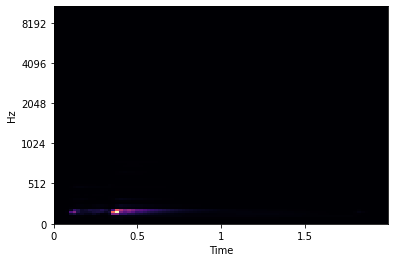

In [19]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [20]:
y, sr = librosa.load(DATA_DIR_GUITAR+data_df_raw['file_path'].iloc[201],duration=2)
ps = librosa.feature.melspectrogram(y=y, sr=sr,)
ps.shape


(128, 55)

<AxesSubplot:xlabel='Time', ylabel='Hz'>

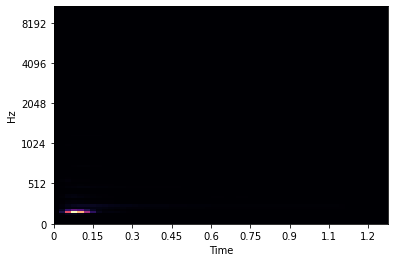

In [21]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [22]:
y, sr = librosa.load(DATA_DIR_GUITAR+data_df_raw['file_path'].iloc[401],duration=2)
ps = librosa.feature.melspectrogram(y=y, sr=sr,)
ps.shape


(128, 67)

<AxesSubplot:xlabel='Time', ylabel='Hz'>

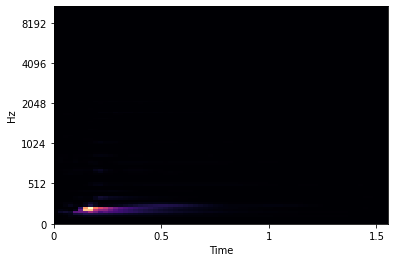

In [23]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [24]:
y, sr = librosa.load(DATA_DIR_GUITAR+data_df_raw['file_path'].iloc[801],duration=2)
ps = librosa.feature.melspectrogram(y=y, sr=sr,)
ps.shape


(128, 62)

<AxesSubplot:xlabel='Time', ylabel='Hz'>

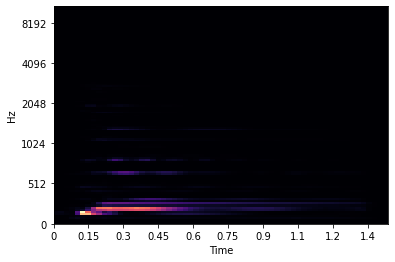

In [25]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

## Training

### Load processed data

In [6]:
dataset = pd.read_pickle(os.path.join(METADATA_DIR_PROCESSED, 'data.pkl'))

In [13]:
print("Number of samples: ", len(dataset))

Number of samples:  28


In [22]:
dataset.iloc[0]

spectrogram    [[0.00012578518248171133, 0.000171102419808094...
class_ID                                                       7
class_name                                                    em
Name: 0, dtype: object

In [18]:
dataset['spectrogram'].iloc[0].shape

(128, 87)

### Splitting into train and test

In [7]:
np.random.seed(42)
sample = np.random.choice(dataset.index, size=int(len(dataset)*0.8), replace=False)
train_data, test_data = dataset.iloc[sample], dataset.drop(sample)


print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])

Number of training samples is 22
Number of testing samples is 6
                                          spectrogram  class_ID class_name
9   [[0.0003063684174560551, 0.0003068112751024809...         3          c
25  [[0.00011310513755979318, 0.000118863539866071...         8          f
8   [[0.000115866739310853, 9.211821605442563e-05,...         1         am
21  [[0.00012578518248171133, 0.000171102419808094...         7         em
0   [[0.00012578518248171133, 0.000171102419808094...         7         em
12  [[0.0003193784823874194, 0.0002055453657872741...         3          c
17  [[7.582858083100617e-06, 1.8382775001556855e-0...         4          d
22  [[0.00012578518248171133, 0.000171102419808094...         7         em
11  [[1.0692516216375007e-05, 7.939112902153468e-0...         3          c
13  [[0.000115866739310853, 9.211821605442563e-05,...         1         am
                                          spectrogram  class_ID class_name
6   [[0.0002605750605048622, 0.00035

In [20]:
train_data['spectrogram'].iloc[0]

array([[5.65288977e-04, 5.36270516e-04, 6.26447347e-04, ...,
        1.43405886e-03, 6.05617887e-03, 6.47266243e-03],
       [6.46477881e-06, 2.36362204e-04, 2.60513446e-04, ...,
        6.51828727e-05, 6.49995746e-05, 1.55495322e-04],
       [6.25565286e-05, 4.44503197e-03, 4.20235398e-02, ...,
        2.61672879e-04, 3.28281934e-04, 3.03510980e-04],
       ...,
       [2.62053156e-08, 1.10005528e-06, 2.32178720e-06, ...,
        3.78386649e-08, 5.61499221e-08, 2.41081409e-08],
       [1.50246137e-08, 5.73511158e-07, 1.23312087e-06, ...,
        1.35735864e-08, 2.31483559e-08, 1.84736541e-08],
       [6.86918613e-09, 1.07577731e-08, 1.82660494e-08, ...,
        7.04329017e-10, 1.51185975e-09, 2.04512156e-09]])

In [21]:
print(train_data.iloc[0])
print(train_data.iloc[0][0].shape)   #shape of input image
print(train_data.iloc[0][0][0][1])
print(train_data.iloc[0][1])    #output class id

spectrogram    [[0.0005652889772970222, 0.0005362705158330562...
class_ID                                                       0
class_name                                                     a
Name: 174, dtype: object
(128, 87)
0.0005362705158330562
0


## Splitting the data into features (X) and targets (y)
Now, as a final step before the training, we'll split the data into features (X) and targets (y).

In [8]:
X_train = train_data['spectrogram']
y_train = train_data['class_ID']
X_test = test_data['spectrogram']
y_test = test_data['class_ID']

print(X_test[:10])
print(y_test[:10])

6     [[0.0002605750605048622, 0.0003518248208546959...
7     [[7.710649287595419e-05, 3.860329658849771e-05...
10    [[0.00023319479653677324, 0.000198659740522765...
14    [[7.710649287595419e-05, 3.860329658849771e-05...
19    [[0.0002605750605048622, 0.0003518248208546959...
20    [[0.00012578518248171133, 0.000171102419808094...
Name: spectrogram, dtype: object
6     5
7     1
10    3
14    1
19    5
20    7
Name: class_ID, dtype: int64


### Reshape for CNN input

In [9]:
X_train = np.array([x.reshape( (128, 87, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 87, 1) ) for x in X_test])

In [24]:
print(X_train[0].shape)
print(y_train[0])

(128, 87, 1)
7


### One-Hot encoding for classes

In [10]:
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test_values=y_test
y_test = np.array(keras.utils.to_categorical(y_test, 10))

In [26]:
print(y_train[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Model

In [11]:
model = Sequential()
input_shape=(128, 87, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

In [11]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 83, 24)       624       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 41, 24)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 31, 41, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 37, 48)        28848     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 18, 48)         0         
_________________________________________________________________
activation_2 (Activation)    (None, 6, 18, 48)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 14, 48)         57648     
__________

In [12]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)

In [13]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy', precision, recall,fmeasure])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=70,
    batch_size=20,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test f1-score:', score[4])


Train on 22 samples, validate on 6 samples
Epoch 1/70


In [31]:
y_test_values.shape

(230,)

In [32]:
predictions = model.predict_classes(X_test)

In [33]:
conf_mat=confusion_matrix(y_test_values, predictions, labels=range(10))
conf_mat

array([[24,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 27,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 26,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 21,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 16,  3,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  8,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0, 19,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 27,  0,  1],
       [ 0,  0,  0,  1,  0,  0,  0,  0, 19,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 30]])

### Save model to disk

### serialize model to JSON

In [34]:
model_json = model.to_json()
with open(MODEL_JSON, "w") as json_file:
    json_file.write(model_json)

### serialize weights to HDF5

In [35]:
model.save_weights(MODEL_H5)
print("Saved model to disk")

Saved model to disk


## Data Augmentation

In [1]:
def get_augmentation_count(df):
    return df['augmentation'].value_counts()

In [219]:
data_df_raw = pd.read_pickle(os.path.join(METADATA_DIR_RAW, 'data.pkl'))

### 1. Vary Time

In [ ]:
data_df_time_inc = augment_data(data_df_raw.copy(), kind='time', rate=1.07)
                    

data_df_time_dec = augment_data(data_df_raw.copy(), kind='time', rate=0.81)

### 2. Vary pitch

In [239]:
data_df_shift_20 = augment_data(data_df_raw.copy(), kind='pitch', rate=2.5)

data_df_shift_25 = augment_data(data_df_raw.copy(), kind='pitch', rate=2)

After applying augment_data, shape of df = (4000, 8)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation'],
      dtype='object')

After applying augment_data, shape of df = (4000, 8)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation'],
      dtype='object')



### Create Augmented Metada

In [264]:
data_df_raw['augmentation'] = 'None'
data_df_augmented_raw = pd.concat([data_df_raw, data_df_time_inc, data_df_time_dec, data_df_shift_20, data_df_shift_25], axis=0)

In [284]:
data_df_augmented_raw = data_df_augmented_raw.pipe(add_shape)

After applying add_shape, shape of df = (16000, 9)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation', 'shape'],
      dtype='object')



In [312]:
print(get_augmentation_count(data_df_augmented_raw))

After applying get_augmentation_count, shape of df = (5,)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation', 'shape'],
      dtype='object')

None         8000
pitch_250    2000
pitch_200    2000
speed_81     2000
speed_107    2000
Name: augmentation, dtype: int64


In [286]:
print(get_count(data_df_augmented_raw))

After applying get_count, shape of df = (10,)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation', 'shape'],
      dtype='object')

e     1600
d     1600
a     1600
g     1600
am    1600
c     1600
bm    1600
f     1600
dm    1600
em    1600
Name: class_name, dtype: int64


In [282]:
data_df_augmented_raw.head()

,file_path,file_name,class_name,class_ID,y,sr,spectrogram,augmentation,shape
0,g/speed_107/g102.wav,g102.wav,g,9,"[-0.07182093, -0.10744891, -0.06559521, -0.086...",22050,"[[0.009544356, 0.18455605, 1.1824054, 0.513804...",speed_107,"(128, 71)"
1,g/speed_107/g194.wav,g194.wav,g,9,"[0.0042471434, 0.0057702884, 0.005924746, 0.00...",22050,"[[0.0091888, 0.0096358005, 0.0052495273, 0.006...",speed_107,"(128, 72)"
2,g/speed_107/g144.wav,g144.wav,g,9,"[-1.4150559e-05, 0.0011950773, 0.0038850766, 0...",22050,"[[0.02301405, 0.013076712, 0.005735046, 0.0057...",speed_107,"(128, 81)"
3,g/speed_107/g160.wav,g160.wav,g,9,"[-0.00116409, -0.00061268755, -0.00042036132, ...",22050,"[[0.0030068015, 0.008565176, 0.016034044, 0.00...",speed_107,"(128, 81)"
4,g/speed_107/g129.wav,g129.wav,g,9,"[-0.005619276, -0.006499503, 0.00010849091, 0....",22050,"[[0.011926388, 0.008582427, 0.0061589293, 0.00...",speed_107,"(128, 81)"


### Save augmented raw data

In [268]:
data_df_augmented_raw.to_csv(os.path.join(METADATA_DIR_AUGMENTED_RAW, 'data.csv'), index=False)


After applying get_count, shape of df = (10,)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation'],
      dtype='object')

e     1600
d     1600
a     1600
g     1600
am    1600
c     1600
bm    1600
f     1600
dm    1600
em    1600
Name: class_name, dtype: int64


### Process and save processed augmented data

In [10]:
data_df_augmented_raw = pd.read_pickle(os.path.join(METADATA_DIR_AUGMENTED_RAW, 'data.pkl'))

In [13]:
# Maintain same shape
@df_info
def clean_shape(df):
    max_shape = df['spectrogram'].map(lambda x: x.shape).value_counts().index[0]
    print(f"The most frequent shape is {max_shape}")
    df['shape'] = df['spectrogram'].map(lambda x: x.shape)
    df = df[df['shape']==max_shape]
    df.drop(columns='shape', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

@df_info
def process_augmented(df):
    df = (df.pipe(clean_shape)
            .pipe(over_sample)
    )
    df = df[['spectrogram','class_ID', 'class_name', 'augmentation']]
    
    return df

#Over sampling data
@df_info
def over_sample(df):
    oversample = RandomOverSampler(sampling_strategy='auto')
    X, y = df[['spectrogram', 'augmentation']].values, df['class_ID'].values
#     X = X.reshape(-1, 1)
    X, y = oversample.fit_resample(X, y)
    df = pd.DataFrame()
    df['spectrogram'] = pd.Series([np.array(x[0]) for x in X])
    df['augmentation'] = pd.Series([np.array(x[1]) for x in X])
    df['augmentation'] = df['augmentation'].map(lambda x: str(x))
    df['class_ID'] = pd.Series(y)
    df['class_name'] = df['class_ID'].map(lambda x: get_class(x))
    return df

In [12]:
data_df_augmented_processed = process_augmented(data_df_augmented_raw)

In [288]:
data_df_augmented_processed.to_csv(os.path.join(METADATA_DIR_AUGMENTED_PROCESSED, 'data.csv'), index=False)
data_df_augmented_processed.to_pickle(os.path.join(METADATA_DIR_AUGMENTED_PROCESSED, 'data.pkl'))

The most frequent shape is (128, 87)
After applying clean_shape, shape of df = (3830, 8)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation', 'shape'],
      dtype='object')

After applying process_augmented, shape of df = (3830, 4)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation', 'shape'],
      dtype='object')



In [290]:
print(get_count(data_df_augmented_processed))

After applying get_count, shape of df = (10,)
Columns of df are Index(['spectrogram', 'class_ID', 'class_name', 'augmentation'], dtype='object')

c     691
am    578
e     558
g     531
d     524
dm    279
em    275
a     185
f     173
bm     36
Name: class_name, dtype: int64


In [296]:
print(get_augmentation_count(data_df_augmented_processed))

After applying get_augmentation_count, shape of df = (4,)
Columns of df are Index(['spectrogram', 'class_ID', 'class_name', 'augmentation'], dtype='object')

None         2532
pitch_200     633
pitch_250     633
speed_81       32
Name: augmentation, dtype: int64


The dataset consists of:
- 1-633 normal samples.
- 634-981 samples speed up by 1.07.
- 982-2594 samples Slowed down to 0.81.
- 2595-3227 samples Pitch modulated 2 semitones higher.
- 3228-3860 samples Pitch modulated 2.5 semitones higher.





### Load processed augmented data

In [291]:
dataset = pd.read_pickle(os.path.join(METADATA_DIR_AUGMENTED_PROCESSED, 'data.pkl'))

In [292]:
print("Number of samples: ", len(dataset))

Number of samples:  3830


In [293]:
dataset.iloc[0]

spectrogram     [[0.023263648, 0.013200079, 0.005690117, 0.005...
class_ID                                                        9
class_name                                                      g
augmentation                                                 None
Name: 0, dtype: object

In [294]:
dataset['spectrogram'].iloc[0].shape

(128, 87)

### Splitting into train and test

In [295]:
np.random.seed(42)
sample = np.random.choice(dataset.index, size=int(len(dataset)*0.8), replace=False)
train_data, test_data = dataset.iloc[sample], dataset.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])

Number of training samples is 3064
Number of testing samples is 766
                                            spectrogram  class_ID class_name  \
2922  [[0.00019362751, 0.00020689117, 0.00017715132,...         8          f   
3716  [[0.005589589, 0.005713801, 0.0062338435, 0.00...         6          e   
1964  [[0.0058204937, 0.005927953, 0.0057165334, 0.0...         9          g   
3621  [[0.00064211176, 0.0005400054, 0.00063801196, ...         0          a   
1694  [[0.012214066, 0.0051321704, 0.0035163227, 0.0...         7         em   
1157  [[0.007482484, 0.0071817273, 0.007316982, 0.00...         6          e   
318   [[0.0013349487, 0.0008135946, 0.00034707907, 0...         5         dm   
839   [[0.046818838, 0.026844991, 0.009680895, 0.007...         1         am   
893   [[0.00609399, 0.0014312841, 4.5376742e-05, 4.6...         3          c   
985   [[5.567563e-05, 7.225462e-05, 0.00010913082, 0...         5         dm   

     augmentation  
2922    pitch_200  
3716       

In [297]:
train_data['spectrogram'].iloc[0]

array([[1.9362751e-04, 2.0689117e-04, 1.7715132e-04, ..., 7.8186815e-05,
        2.1387306e-04, 2.3202693e-04],
       [2.0357800e-06, 1.5576363e-06, 5.1439069e-06, ..., 2.0222674e-06,
        3.8249955e-06, 2.2311793e-05],
       [9.7707853e-06, 8.3493305e-06, 2.2361973e-04, ..., 3.7016266e-06,
        5.5294618e-06, 3.0655599e-05],
       ...,
       [1.3973332e-08, 2.1376330e-08, 1.2206337e-07, ..., 1.0000371e-08,
        8.3683416e-09, 9.9608970e-09],
       [7.7119653e-09, 7.1859856e-09, 1.8832310e-08, ..., 1.8183540e-09,
        1.9158120e-09, 2.4459623e-09],
       [8.5486302e-09, 2.8051879e-09, 3.3572976e-09, ..., 1.4130125e-10,
        2.4894264e-10, 1.1311369e-09]], dtype=float32)

In [298]:
print(train_data.iloc[0])
print(train_data.iloc[0][0].shape)   #shape of input image
print(train_data.iloc[0][0][0][1])
print(train_data.iloc[0][1])    #output class id

spectrogram     [[0.00019362751, 0.00020689117, 0.00017715132,...
class_ID                                                        8
class_name                                                      f
augmentation                                            pitch_200
Name: 2922, dtype: object
(128, 87)
0.00020689117
8


## Splitting the data into features (X) and targets (y)
Now, as a final step before the training, we'll split the data into features (X) and targets (y).

In [299]:
X_train = train_data['spectrogram']
y_train = train_data['class_ID']
X_test = test_data['spectrogram']
y_test = test_data['class_ID']

print(X_train[:10])
print(y_train[:10])

2922    [[0.00019362751, 0.00020689117, 0.00017715132,...
3716    [[0.005589589, 0.005713801, 0.0062338435, 0.00...
1964    [[0.0058204937, 0.005927953, 0.0057165334, 0.0...
3621    [[0.00064211176, 0.0005400054, 0.00063801196, ...
1694    [[0.012214066, 0.0051321704, 0.0035163227, 0.0...
1157    [[0.007482484, 0.0071817273, 0.007316982, 0.00...
318     [[0.0013349487, 0.0008135946, 0.00034707907, 0...
839     [[0.046818838, 0.026844991, 0.009680895, 0.007...
893     [[0.00609399, 0.0014312841, 4.5376742e-05, 4.6...
985     [[5.567563e-05, 7.225462e-05, 0.00010913082, 0...
Name: spectrogram, dtype: object
2922    8
3716    6
1964    9
3621    0
1694    7
1157    6
318     5
839     1
893     3
985     5
Name: class_ID, dtype: int64


### Reshape for CNN input

In [300]:
X_train = np.array([x.reshape( (128, 87, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 87, 1) ) for x in X_test])

In [301]:
print(X_train[0].shape)
print(y_train[0])

(128, 87, 1)
9


### One-Hot encoding for classes

In [302]:
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test_values=y_test
y_test = np.array(keras.utils.to_categorical(y_test, 10))

In [303]:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


### Model

In [306]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 124, 83, 24)       624       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 41, 24)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 31, 41, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 37, 48)        28848     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 18, 48)         0         
_________________________________________________________________
activation_7 (Activation)    (None, 6, 18, 48)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 14, 48)        

In [307]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy', precision, recall,fmeasure])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=70,
    batch_size=20,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test f1-score:', score[4])


Train on 3064 samples, validate on 766 samples
Epoch 1/70
3064/3064 [==============================] - 11s 4ms/step - loss: 2.1842 - accuracy: 0.1988 - precision: 0.2808 - recall: 0.0286 - fmeasure: 0.0498 - val_loss: 1.9612 - val_accuracy: 0.2546 - val_precision: 0.4301 - val_recall: 0.0436 - val_fmeasure: 0.0762
Epoch 2/70
3064/3064 [==============================] - 9s 3ms/step - loss: 1.9245 - accuracy: 0.2725 - precision: 0.6000 - recall: 0.0870 - fmeasure: 0.1470 - val_loss: 1.7740 - val_accuracy: 0.3433 - val_precision: 0.6996 - val_recall: 0.1504 - val_fmeasure: 0.2383
Epoch 3/70
3064/3064 [==============================] - 10s 3ms/step - loss: 1.7537 - accuracy: 0.3636 - precision: 0.7929 - recall: 0.1880 - fmeasure: 0.2967 - val_loss: 1.6002 - val_accuracy: 0.4034 - val_precision: 0.7670 - val_recall: 0.2427 - val_fmeasure: 0.3582
Epoch 4/70
3064/3064 [==============================] - 9s 3ms/step - loss: 1.6041 - accuracy: 0.4227 - precision: 0.8843 - recall: 0.2669 - fmeasu

3064/3064 [==============================] - 8s 3ms/step - loss: 0.1849 - accuracy: 0.9367 - precision: 0.9514 - recall: 0.9208 - fmeasure: 0.9355 - val_loss: 0.4594 - val_accuracy: 0.9269 - val_precision: 0.9371 - val_recall: 0.9124 - val_fmeasure: 0.9240
Epoch 62/70
3064/3064 [==============================] - 9s 3ms/step - loss: 0.1772 - accuracy: 0.9422 - precision: 0.9554 - recall: 0.9305 - fmeasure: 0.9424 - val_loss: 0.2911 - val_accuracy: 0.9269 - val_precision: 0.9336 - val_recall: 0.9124 - val_fmeasure: 0.9224
Epoch 63/70
3064/3064 [==============================] - 8s 2ms/step - loss: 0.3288 - accuracy: 0.9063 - precision: 0.9315 - recall: 0.8932 - fmeasure: 0.9114 - val_loss: 0.3521 - val_accuracy: 0.9256 - val_precision: 0.9360 - val_recall: 0.9124 - val_fmeasure: 0.9236
Epoch 64/70
3064/3064 [==============================] - 8s 3ms/step - loss: 0.2975 - accuracy: 0.9063 - precision: 0.9228 - recall: 0.8896 - fmeasure: 0.9054 - val_loss: 0.5131 - val_accuracy: 0.9191 - va

In [309]:
predictions = model.predict_classes(X_test)

In [310]:
conf_mat=confusion_matrix(y_test_values, predictions, labels=range(10))
conf_mat

array([[ 22,   1,   3,   0,   1,   0,   0,   0,   0,   2],
       [  0, 107,   1,   1,   0,   1,   0,   0,   0,   0],
       [  0,   0,   4,   0,   0,   0,   1,   0,   0,   1],
       [  0,   0,   0, 132,   1,   0,   1,   0,   1,   0],
       [  0,   1,   0,   1, 106,   1,   0,   1,   0,   0],
       [  0,   2,   0,   0,  17,  32,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 122,   3,   0,   0],
       [  0,   0,   0,   3,   0,   0,   6,  70,   1,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,  30,   1],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0,  86]])

### Save model to disk

### serialize model to JSON

In [36]:
model_json = model.to_json()
with open(os.path.join(MODEL_DIR, 'model_1.json'), "w") as json_file:
    json_file.write(model_json)

### serialize weights to HDF5

In [37]:
model.save_weights(os.path.join(MODEL_DIR, 'model_1.h5'))
print("Saved model to disk")

Saved model to disk


In [530]:
df.apply(lambda x: x['class_name'] if not x['class_name'])

SyntaxError: invalid syntax (<ipython-input-530-9deeb658d4ff>, line 1)

In [539]:
mask = (df['class_ID']==9)

In [540]:
df[mask]

,spectrogram,class_ID,class_name
0,"[[0.023263648, 0.013200079, 0.005690117, 0.005...",9,g
1,"[[0.0030921197, 0.008742289, 0.01737749, 0.010...",9,g
2,"[[0.011711276, 0.00850786, 0.006172516, 0.0059...",9,g
3,"[[0.008072537, 0.006353717, 0.0074853124, 0.00...",9,g
4,"[[0.0064443834, 0.007321003, 0.0068667047, 0.0...",9,g
...,...,...,...
1145,"[[0.0031992316, 0.0072675794, 0.0061215893, 0....",9,g
1146,"[[0.0055688657, 0.0057151928, 0.005380762, 0.0...",9,g
1147,"[[0.006491574, 0.006028326, 0.014432897, 0.021...",9,g
1148,"[[0.006491574, 0.006028326, 0.014432897, 0.021...",9,g


In [553]:
x = data_df_raw['file_path'].iloc[0]
os.path.join(DATA_DIR_AUGMENTED, x)

'/home/fm-pc-lt-150/Desktop/Guitar-Chords-recognition/data/audio/augmented/g/g102.wav'

In [554]:
path_exists_mask =  data_df_augmented_raw['file_path'].map(lambda x: not os.path.exists(os.path.join(DATA_DIR_AUGMENTED, x)))

In [555]:
path_exists_mask.value_counts()

True     8000
False    8000
Name: file_path, dtype: int64

In [559]:
data_df_augmented_raw[path_exists_mask]

,file_path,file_name,class_name,class_ID,y,sr,spectrogram,augmentation,shape
0,g/g102.wav,g102.wav,g,9,"[-0.070366405, -0.10625491, -0.06439576, -0.08...",22050,"[[0.009564147, 0.20960604, 1.369052, 0.6042535...",None,"(128, 76)"
1,g/g194.wav,g194.wav,g,9,"[0.003939517, 0.0057145343, 0.0060949815, 0.00...",22050,"[[0.009173464, 0.009723088, 0.0051691546, 0.00...",None,"(128, 77)"
2,g/g144.wav,g144.wav,g,9,"[-0.00017985907, 0.0010203752, 0.0037393924, 0...",22050,"[[0.023263648, 0.013200079, 0.005690117, 0.005...",None,"(128, 87)"
3,g/g160.wav,g160.wav,g,9,"[-0.0008470263, -0.00043425435, -0.00062727876...",22050,"[[0.0030921197, 0.008742289, 0.01737749, 0.010...",None,"(128, 87)"
4,g/g129.wav,g129.wav,g,9,"[-0.006440137, -0.007372321, -0.0007374781, 0....",22050,"[[0.011711276, 0.00850786, 0.006172516, 0.0059...",None,"(128, 87)"
...,...,...,...,...,...,...,...,...,...
1995,d/d166.wav,d166.wav,d,4,"[0.058236524, 0.08123742, 0.056173798, 0.04294...",22050,"[[0.1764211, 0.043822616, 0.0052566878, 0.0060...",None,"(128, 87)"
1996,d/d33.wav,d33.wav,d,4,"[0.00023138247, 0.0002892468, 0.0002360416, 0....",22050,"[[7.337144e-05, 0.00019333852, 9.7900054e-05, ...",None,"(128, 87)"
1997,d/d173.wav,d173.wav,d,4,"[-0.037300956, -0.091728985, -0.06686829, -0.0...",22050,"[[0.07238557, 0.019314304, 0.006020969, 0.0077...",None,"(128, 87)"
1998,d/d145.wav,d145.wav,d,4,"[-0.04395816, -0.05974601, -0.05267904, -0.053...",22050,"[[0.17131603, 0.052995317, 0.0073828846, 0.005...",None,"(128, 78)"
